In [1]:
# import from skimage
from skimage.color import rgb2gray
from skimage.filters import sobel, sobel_h, sobel_v, prewitt, roberts, gaussian
from skimage.feature import canny
import skimage.io as io
import cv2 as cv
import pytesseract

from scipy.spatial import distance as dist

# import from matplotlib
import matplotlib.pyplot as plt

# import from numpy
import numpy as np

# import utils
from utils.commonfunctions import *

#import pandas
import pandas as pd


In [2]:
# img = io.imread("datasets/dataset_module1/01.jpg")

# # read image 1.jpg
# img = cv.imread('dataset/inputs/Five0.png',0)
# read image 1.jpg
img = cv.imread('dataset/Bubble_Data/5_new.jpeg',0)
# colored_img = cv.imread('datasets/dataset_module1/01.jpg')
# img = cv.imread('datasets/dataset_module1/11.jpg',0)

# # convert to greyscale
# grey_scale = img
# # blurredImg = img
# # blurredImg =  cv.medianBlur(img,7)
# blurredImg = cv.GaussianBlur(img,(5,5),0)
# # blurredImg = gaussian(img,sigma = 2)

# print(img.shape)

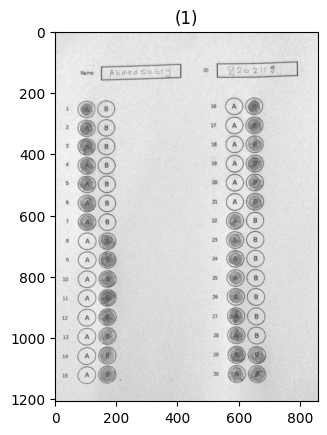

In [3]:
show_images([img])

In [4]:
# binaryImg = cv.adaptiveThreshold(blurredImg,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,59,3)
# # ret,binaryImg = cv.threshold(blurredImg,147,255,cv.THRESH_BINARY)
# show_images([img,blurredImg,binaryImg])

In [5]:
# median =  cv.medianBlur(binaryImg,5)
# median =  cv.medianBlur(median,5)
# show_images([img,blurredImg,binaryImg,median])

In [6]:
# kernel = np.ones((3,3))
# openingImg = opening(median, kernel)
# dilatedImg = dilate(openingImg, kernel)
# show_images([median,openingImg,dilatedImg])

In [7]:
# negativeImg = 255-binaryImg
# kernel = np.ones((7,7))
# erodedImg = erode(negativeImg, kernel)
# show_images([negativeImg,erodedImg,dilatedImg])

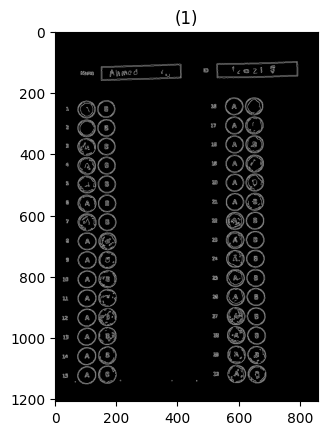

In [8]:
# use canny to detect edges
cannyEdges = cannyEdge(img)

show_images([cannyEdges])

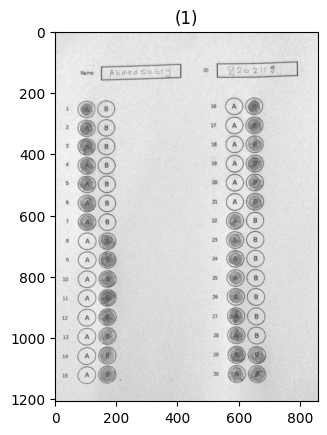

In [9]:
# Finding Contours
# Use a copy of the image e.g. edged.copy()
# since findContours alters the image
img_cpy = img.copy()
img_cpy = cv.adaptiveThreshold(img_cpy,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,59,3)
contours, hierarchy = cv.findContours(cannyEdges, 
    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

sorted_contours = sorted(contours, key=cv.contourArea)

c = max(sorted_contours, key = cv.contourArea)
maxCountourArea = cv.contourArea(c)

transormedImg = img.copy()
if(maxCountourArea > 0.4 * img.shape[0] * img.shape[1]):
    # limit contour to quadrilateral
    peri = cv.arcLength(c, True)
    corners = cv.approxPolyDP(c, 0.04 * peri, True)

    # draw quadrilateral on input image from detected corners
    result = img.copy()
    cv.polylines(result, [corners], True, (0,0,255), 2, cv.LINE_AA)

    show_images([img,result]) 
    
    # print(corners)

    x_list = [corners[0][0][0],corners[1][0][0],corners[2][0][0],corners[3][0][0]]
    y_list = [corners[0][0][1],corners[1][0][1],corners[2][0][1],corners[3][0][1]]
    x_list = np.sort(x_list)
    y_list = np.sort(y_list)

    # print(corners)

    temp_corners = np.squeeze(corners)

    print("temp_corners",temp_corners)

    temp_corners = sorted(temp_corners, key=lambda x: x[0])

    top_left = []
    top_right = []
    bottom_left = []
    bottom_right = []
    if temp_corners[0][1] < temp_corners[1][1]:
        top_left = temp_corners[0]
        top_right = temp_corners[1]
    else:
        top_left = temp_corners[1]
        top_right = temp_corners[0]

    if temp_corners[2][1] < temp_corners[3][1]:
        bottom_left = temp_corners[2]
        bottom_right = temp_corners[3]
    else:
        bottom_left = temp_corners[3]
        bottom_right = temp_corners[2]
    
    height = np.max([top_left[1],top_right[1],bottom_left[1],bottom_right[1]]) - np.min([top_left[1],top_right[1],bottom_left[1],bottom_right[1]]) 
    width = np.max([top_left[0],top_right[0],bottom_left[0],bottom_right[0]]) - np.min([top_left[0],top_right[0],bottom_left[0],bottom_right[0]])
    print(width,height)
    oldPoints = np.float32([top_left,bottom_left,top_right,bottom_right])
    newPoints = np.float32([[0,0],[width,0],[0,height],[width,height]])
    transformationMatrix = cv.getPerspectiveTransform(oldPoints,newPoints)
    transormedImg = cv.warpPerspective(img,transformationMatrix,(width,height))

show_images(images = [transormedImg])

white_img_contours = np.ones(img_cpy.shape)

for contour in sorted_contours:
    x,y,w,h = cv.boundingRect(contour)
    if w/h >= 0.7 and w/h <=1.3 and cv.contourArea(contour) <0.5* img.shape[0]*img.shape[1]:
        cv.fillPoly(white_img_contours, pts =[contour], color=(0,0,0))




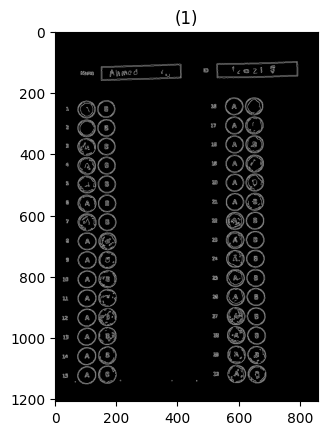

In [10]:
# use canny to detect edges
cannyEdges = cannyEdge(transormedImg)

show_images([cannyEdges])

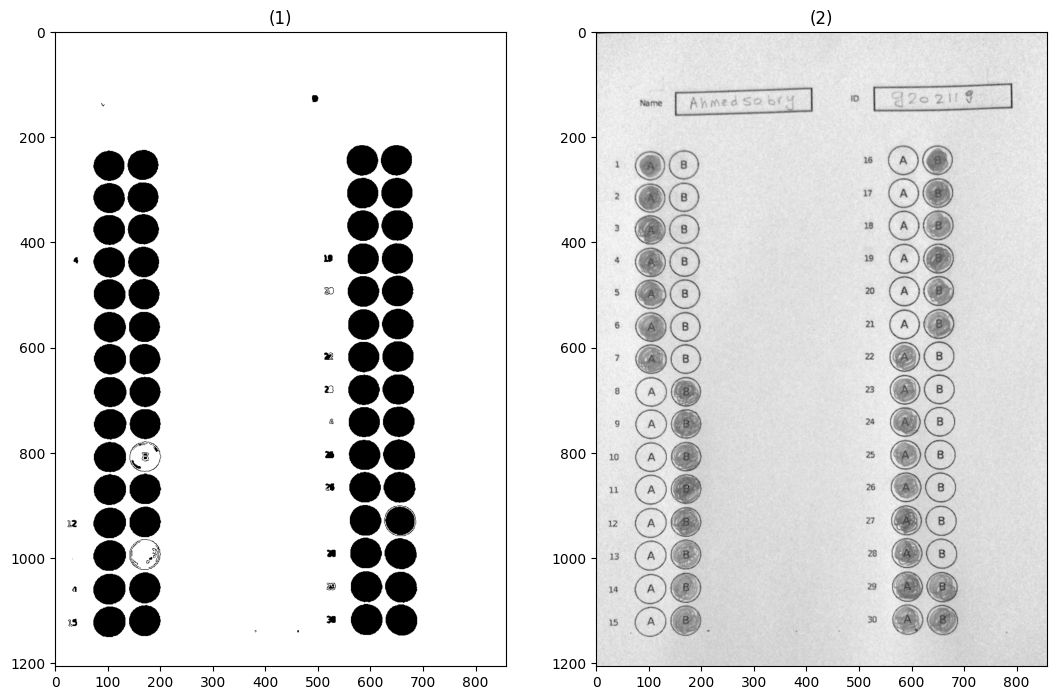

In [11]:
# Finding Contours
# Use a copy of the image e.g. edged.copy()
# since findContours alters the image
img_cpy = transormedImg.copy()
img_cpy = cv.adaptiveThreshold(img_cpy,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,59,3)
contours, hierarchy = cv.findContours(cannyEdges, 
    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

white_img_contours = np.ones(img_cpy.shape)
white_img_contours_IDBox = np.ones(img_cpy.shape)
TwoBox = []
sorted_contours = sorted(contours, key=cv.contourArea)
count_boxes =0;
for contour in sorted_contours:
    x,y,w,h = cv.boundingRect(contour)
    if w/h >= 0.7 and w/h <=1.3:
        cv.fillPoly(white_img_contours, pts =[contour], color=(0,0,0))
    elif w/h > 4:
        cv.fillPoly(white_img_contours_IDBox, pts =[contour], color=(0,0,0))
        if(count_boxes <2):
            TwoBox.append((x,y,w,h))
        count_boxes += 1
show_images([white_img_contours,img])

In [12]:
# Extract Boxes of Name and ID

def Extract_Boxes (img):
    kernel = np.ones((15,15))
    dilatedImg = dilate(img, kernel)
    kernel = np.ones((15,15))
    erodedImg = erode(dilatedImg, kernel)
    
    contours, hierarchy = cv.findContours((255 - erodedImg*255).astype("uint8"), 
    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    white_img_large_contours = np.ones(img_cpy.shape)
    # computes the bounding box for the contour, and draws it on the frame,
    dimensions_contours = []
    for contour in contours:
        (x,y,w,h) = cv.boundingRect(contour)
        dimensions_contours.append( (x,y,w,h))
        cv.rectangle(white_img_large_contours, (x,y), (x+w,y+h), (0, 0, 0), 2)
#     print(dimensions_contours)
    show_images([erodedImg,white_img_large_contours])
    return dimensions_contours

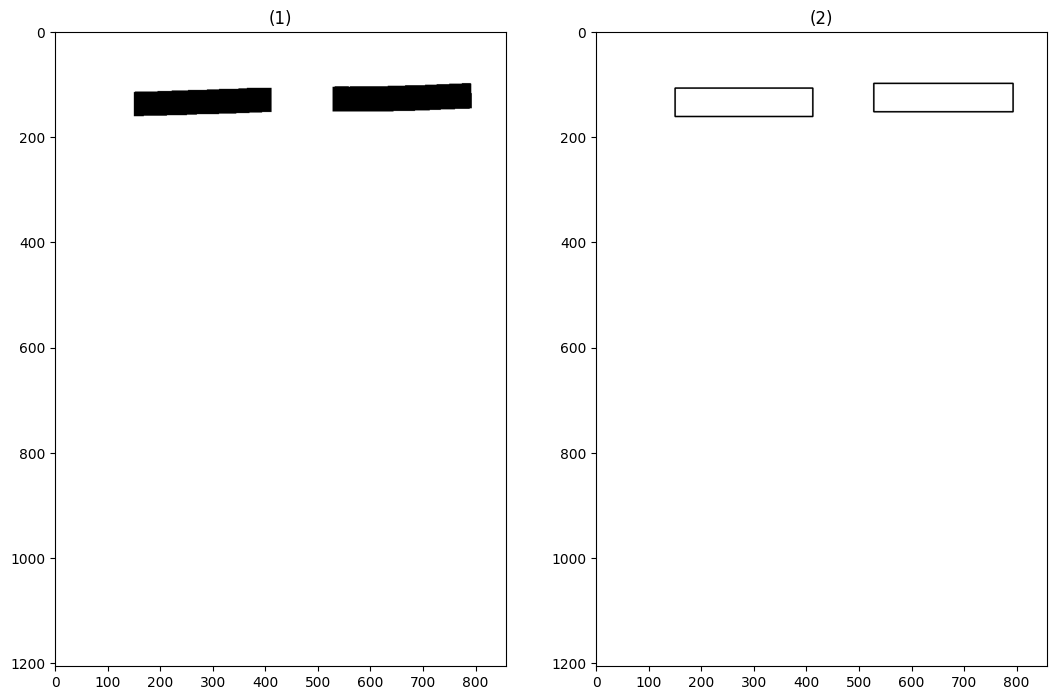

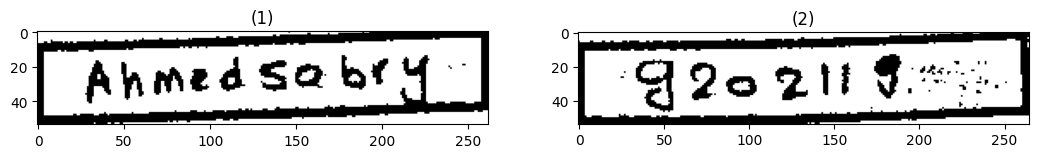

In [13]:
boxes_dimensions = Extract_Boxes(white_img_contours_IDBox)
boxes_croped_images = []
#print(boxes_dimenstions)
for dimension in boxes_dimensions:
    (x,y,w,h) = dimension
    boxes_croped_images.append(img_cpy[y:y+h,x:x+w])
show_images(boxes_croped_images)

In [14]:
def ocr(img, langSelected = "eng"):

    # if it doesn't work :
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    result=[]
    res =''
    try:
        res = pytesseract.image_to_string(img, lang=langSelected)

        # print(arabic)
        if(langSelected == 'ara'):
            arabicText = get_display(res)
            res = arabic_reshaper.reshape(arabicText)
        res =res.strip()
        res =res.replace(" ", "")
    except Exception:
        print("Error!")
    return res

In [15]:
print(ocr(boxes_croped_images[0]))

Ahmedsabry


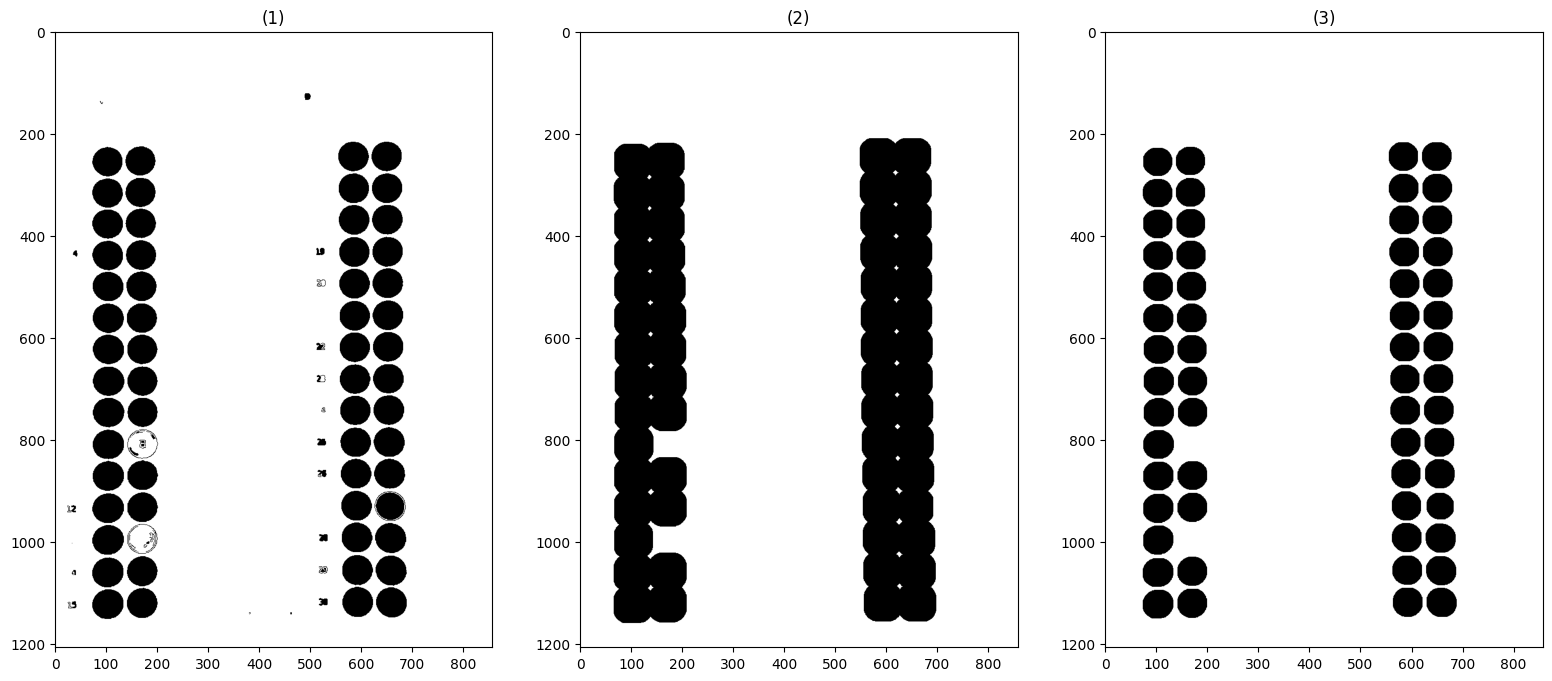

In [16]:
kernel = np.ones((15,15))
dilatedImg = dilate(white_img_contours, kernel)

kernel = np.ones((15,15))
erodedImg2 = erode(dilatedImg, kernel)

kernel = np.ones((18,18))
erodedImg = erode(erodedImg2, kernel)
show_images([white_img_contours,erodedImg,erodedImg2])

[(66, 219, 143, 941), (548, 210, 150, 947)]


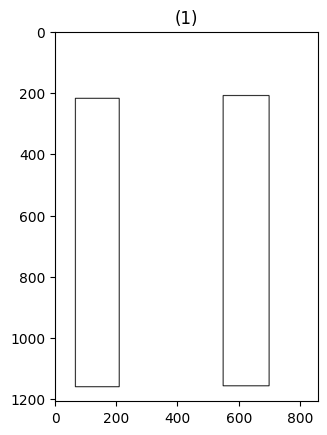

In [17]:
contours, hierarchy = cv.findContours((255 - erodedImg*255).astype("uint8"), 
    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
white_img_large_contours = np.ones(img_cpy.shape)
# computes the bounding box for the contour, and draws it on the frame,
dimensions_contours = []
for contour in contours:
    (x,y,w,h) = cv.boundingRect(contour)
    dimensions_contours.append( (x,y,w,h))
    cv.rectangle(white_img_large_contours, (x,y), (x+w,y+h), (0, 0, 0), 2)
#dimensions_contours = sorted(dimensions_contours, key=lambda dimension: dimension[0])

print(dimensions_contours)
show_images([white_img_large_contours])

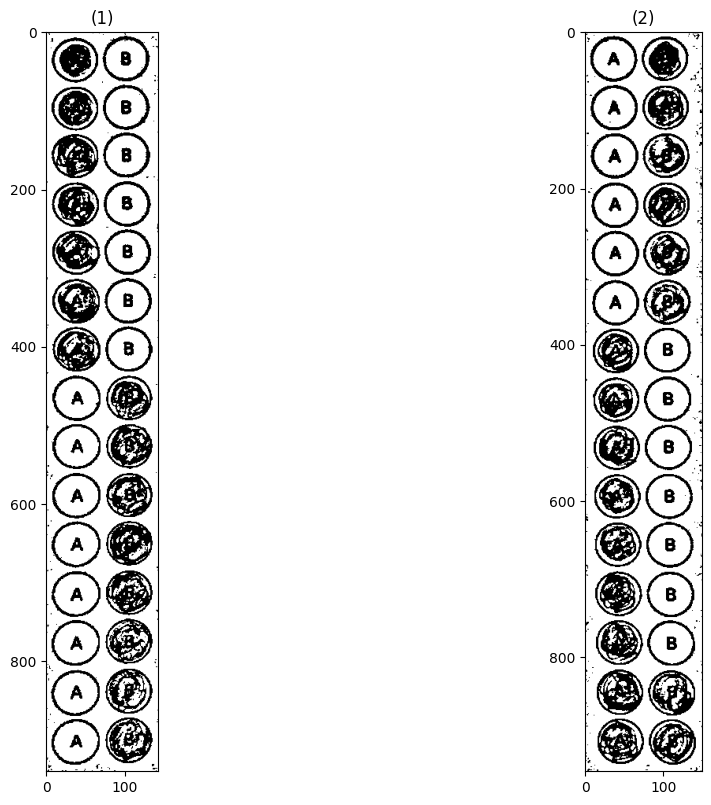

In [18]:
croped_images = []

for dimension in dimensions_contours:
    (x,y,w,h) = dimension
    croped_images.append(img_cpy[y:y+h,x:x+w])
show_images(croped_images)

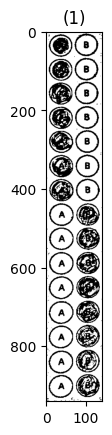

(941, 143)
Here === > 30


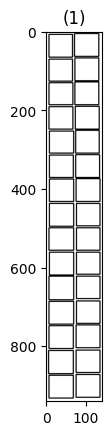

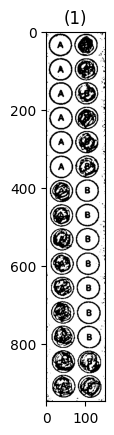

(947, 150)
Here === > 30


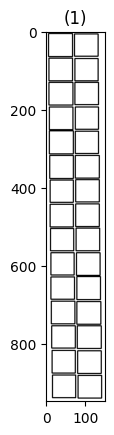

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [19]:
def find_contours_to_rect(img):
    show_images([img])
    contours, hierarchy = cv.findContours((255-img).astype("uint8"), 
    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    white_img_large_contours = np.ones(img.shape)
    # computes the bounding box for the contour, and draws it on the frame,
    print(img.shape)
    sorted_contours = sorted(contours, key=lambda ctr: cv.boundingRect(ctr)[1])
    dimensions_contours = []
    for contour in sorted_contours:
        (x,y,w,h) = cv.boundingRect(contour)
        if w/h >= 0.8 and w/h <=1.4  and w*h > img.shape[0]*img.shape[1]/120:
            dimensions_contours.append((x,y,w,h))
            cv.rectangle(white_img_large_contours, (x,y), (x+w,y+h), (0, 0, 0), 2)
    print("Here === >",len(dimensions_contours))
    return white_img_large_contours,dimensions_contours

contour_cropped_imgs = []
dimensions_cropped_imgs = []
for image in croped_images:
    result_img,result_dimenstion = find_contours_to_rect(image)
    contour_cropped_imgs.append([result_img])
    dimensions_cropped_imgs.append(result_dimenstion)
    show_images([result_img])

contours_count = []
non_overlapped_cnts = []
for dimensions_cropped_img in dimensions_cropped_imgs[0]:
    isOverlapped = False
    for contour in non_overlapped_cnts:
        (x,y,w,h) = dimensions_cropped_img
        (x1,y1,w1,h1) = contour
        if (x>=x1 and x<=x1+w1) or (x+w>=x1 and x+w<=x1+w1):
            isOverlapped = True
            break
    if isOverlapped:
        contours_count.append(len(non_overlapped_cnts))
        non_overlapped_cnts = []
        non_overlapped_cnts.append(dimensions_cropped_img)
    else:
        non_overlapped_cnts.append(dimensions_cropped_img)
    #print(non_overlapped_cnts)
        
print(contours_count)


In [20]:
contours_count = np.array(contours_count)
frequency = [0]*np.max(contours_count+1)

for count in contours_count:
    frequency[count] = frequency[count] + 1
print(frequency)
answer_count = frequency.index(max(frequency))
print(answer_count)


[0, 0, 14]
2


In [21]:
groups_questions_answers = []
for i in range(len(dimensions_cropped_imgs)):
    dimensions_cropped_img = dimensions_cropped_imgs[i]
    question_count = len(dimensions_cropped_img)//answer_count
    questions_answers = []
    print(answer_count,question_count)
    groups_questions_answers.append([])
    for question in range(question_count):
        questions_answers = []
        cropped_answers = []
        for j in range(answer_count):
            (x,y,w,h) = dimensions_cropped_img[question*answer_count+j]
            cropped_answers.append((x,croped_images[i][y:y+h, x:x+w]))
        sorted_cropped_answers = sorted(cropped_answers,key=lambda ans: ans[0])
        
        for cropped_answer in sorted_cropped_answers:
            #show_images([cropped_answer[1]])
            questions_answers.append(cropped_answer[1])
        groups_questions_answers[i].append(questions_answers)
        
        


2 15
2 15


groups_questions_answers 2
group 15


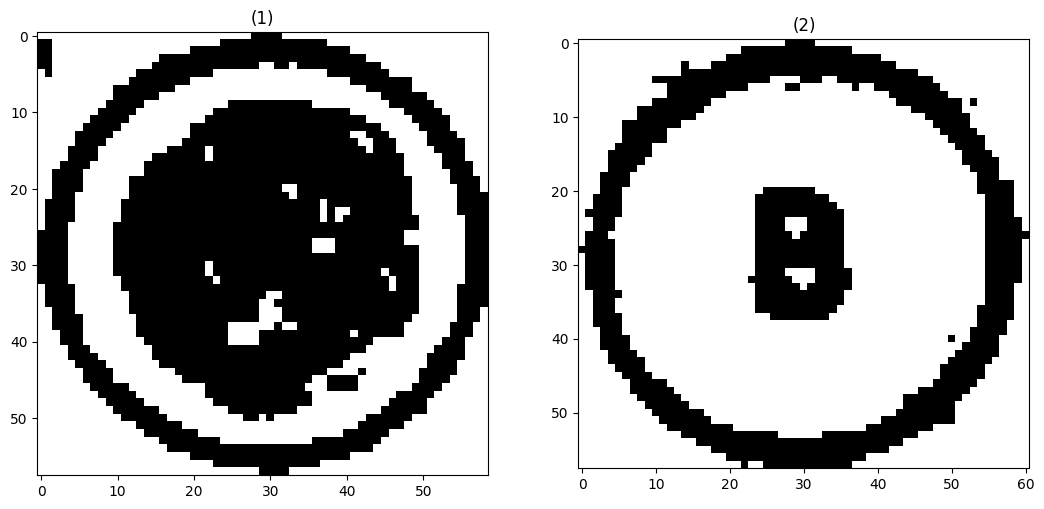

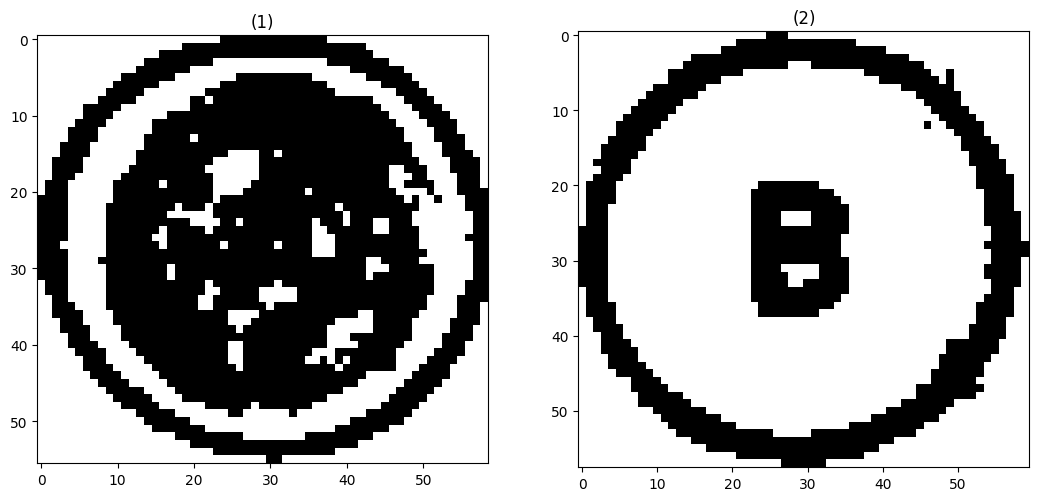

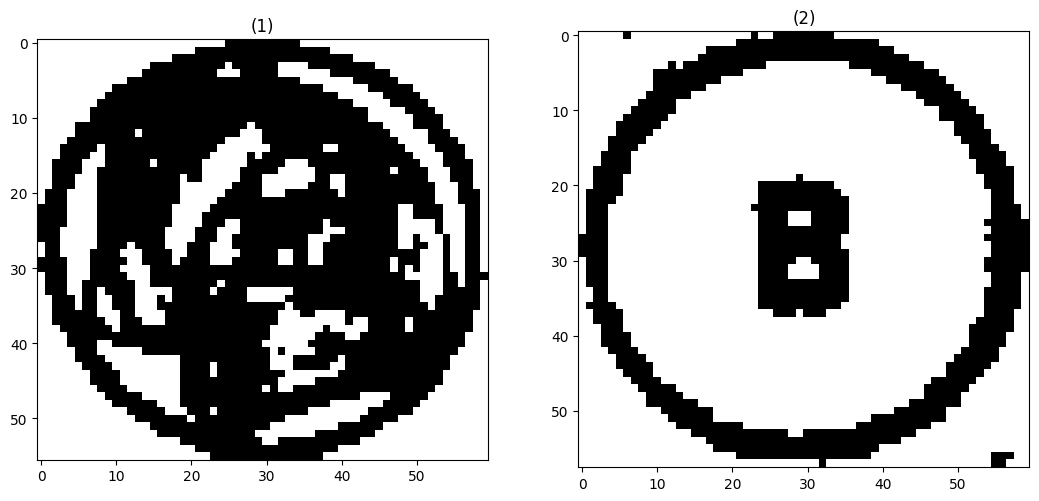

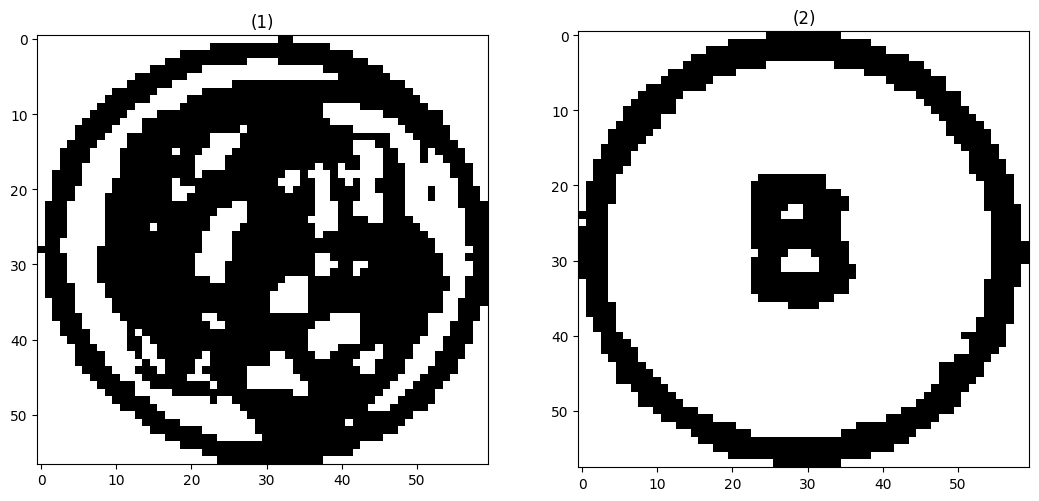

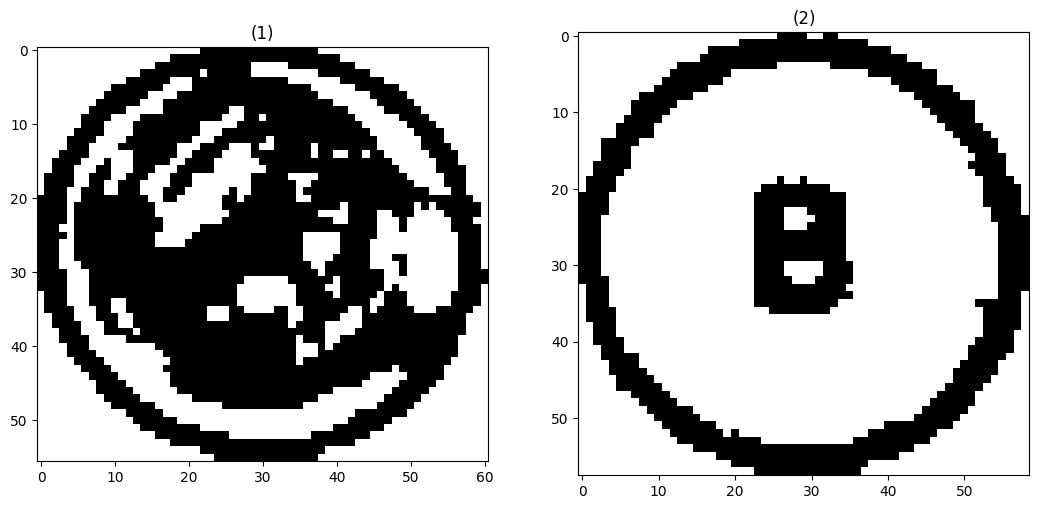

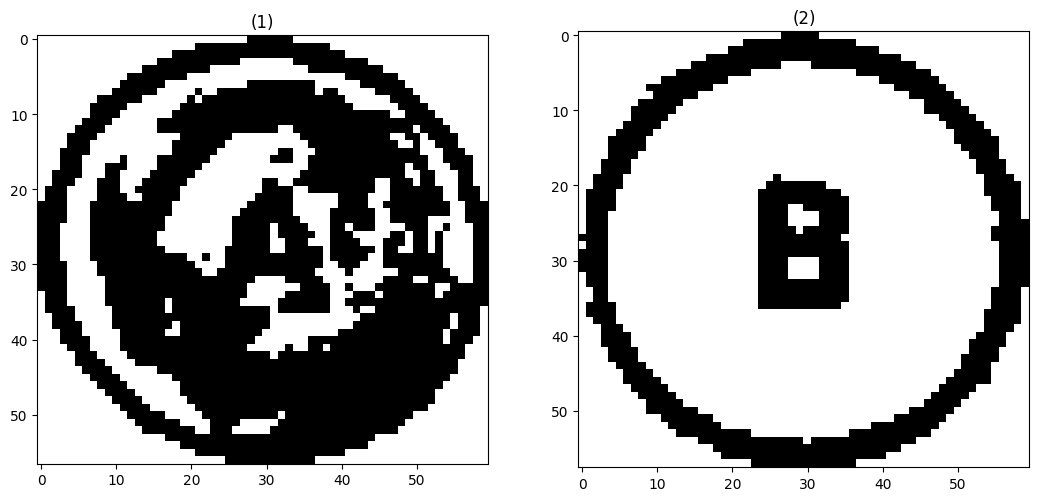

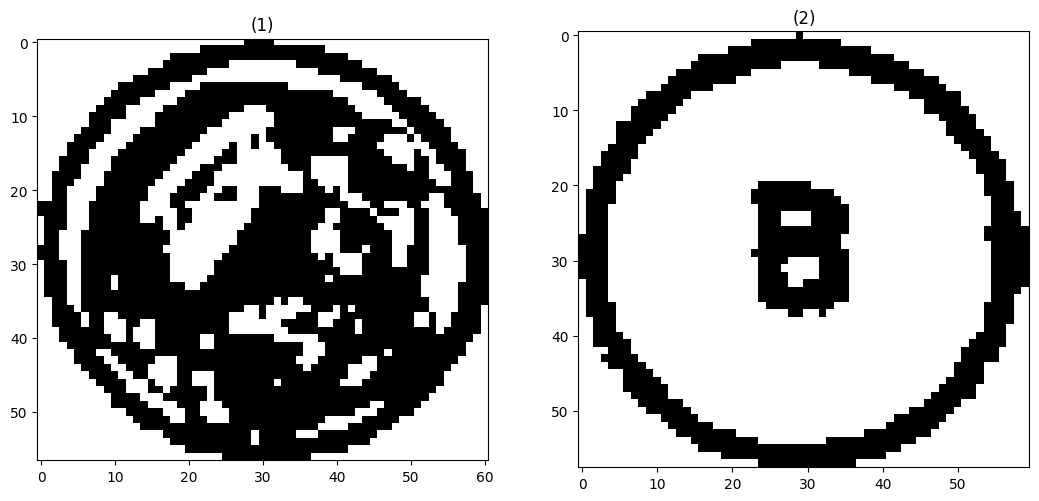

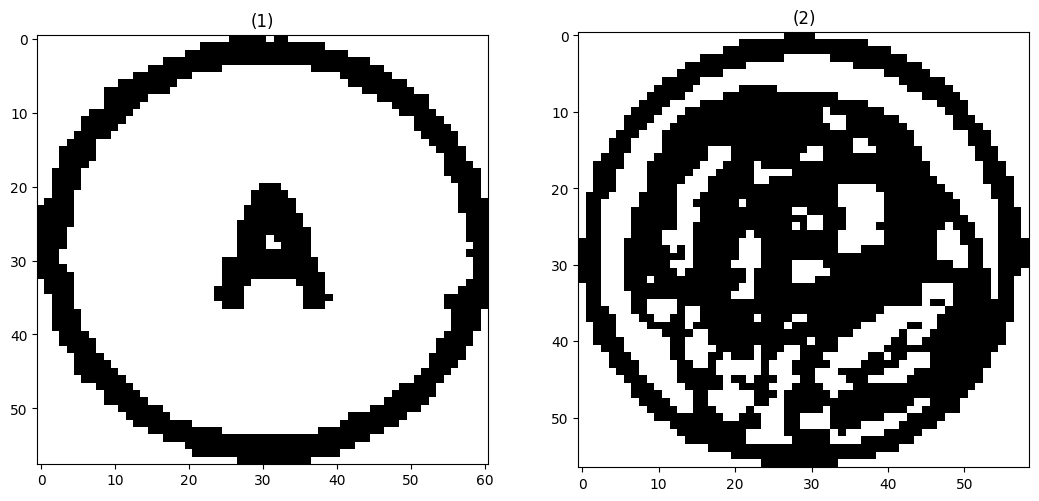

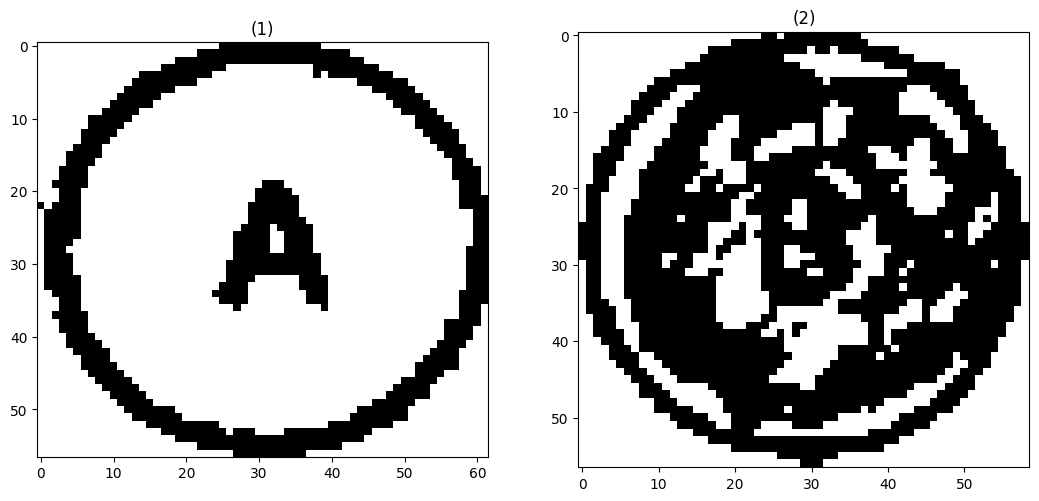

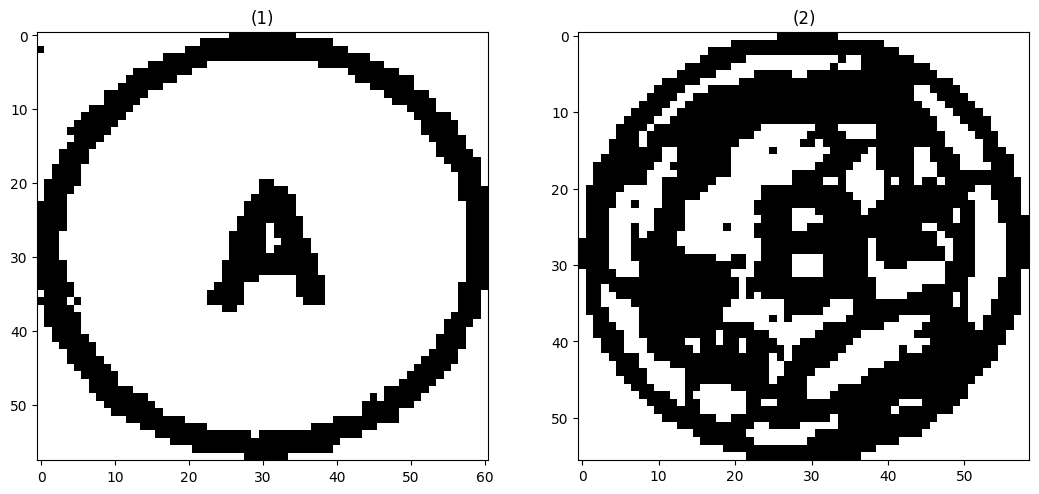

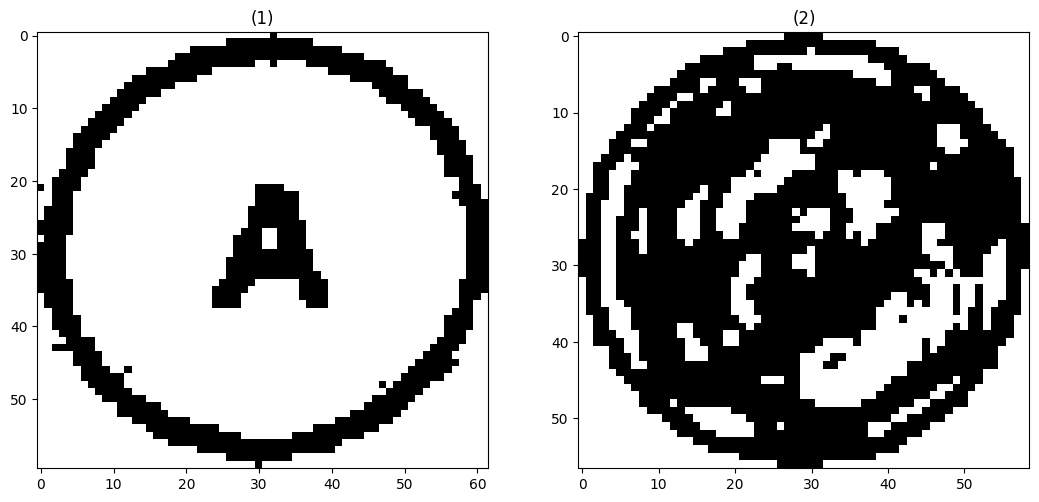

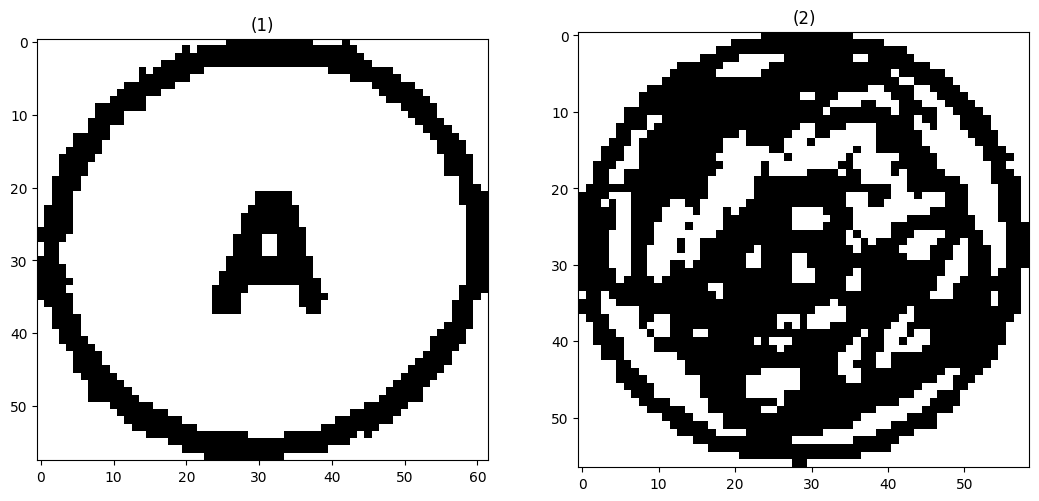

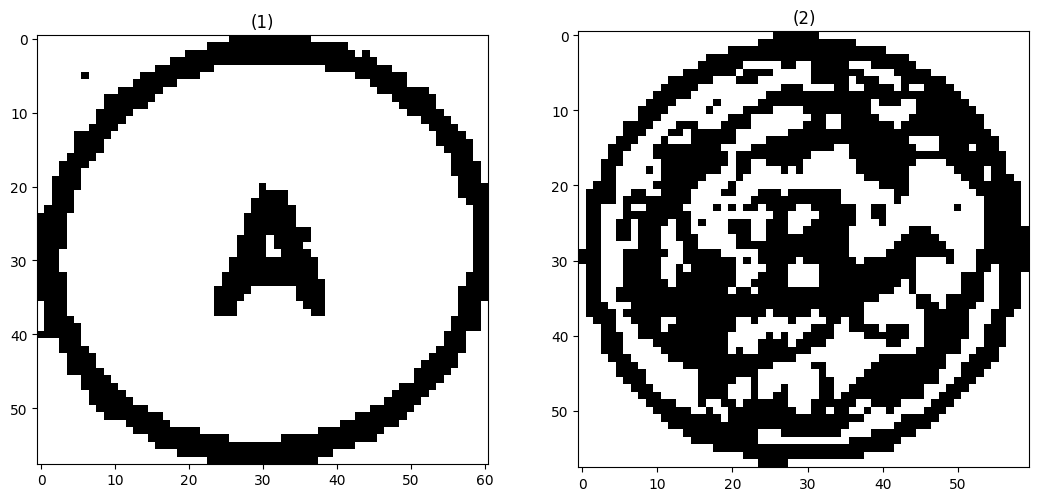

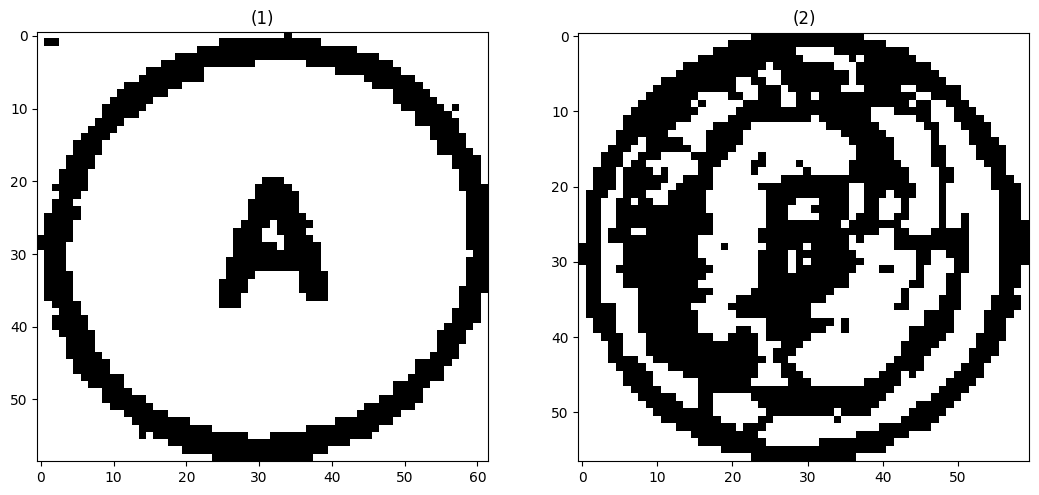

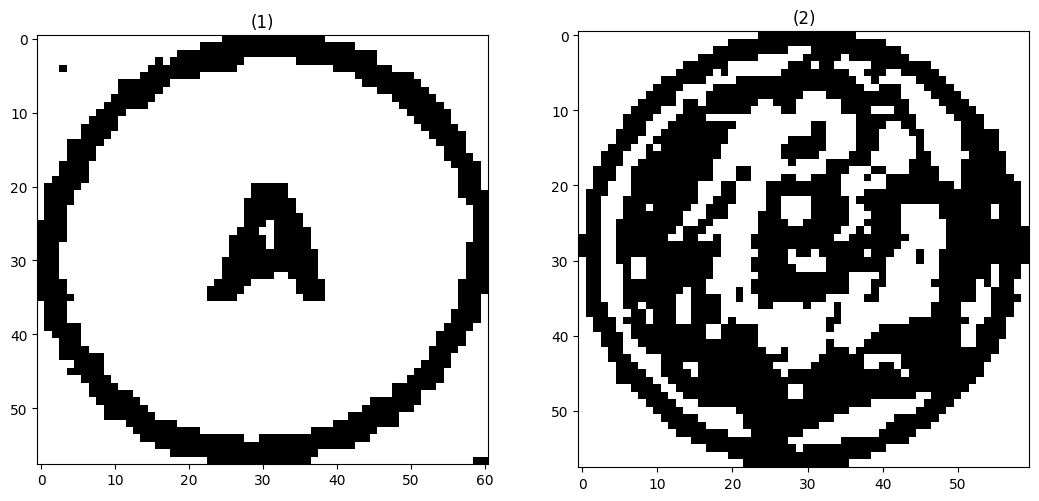

group 15


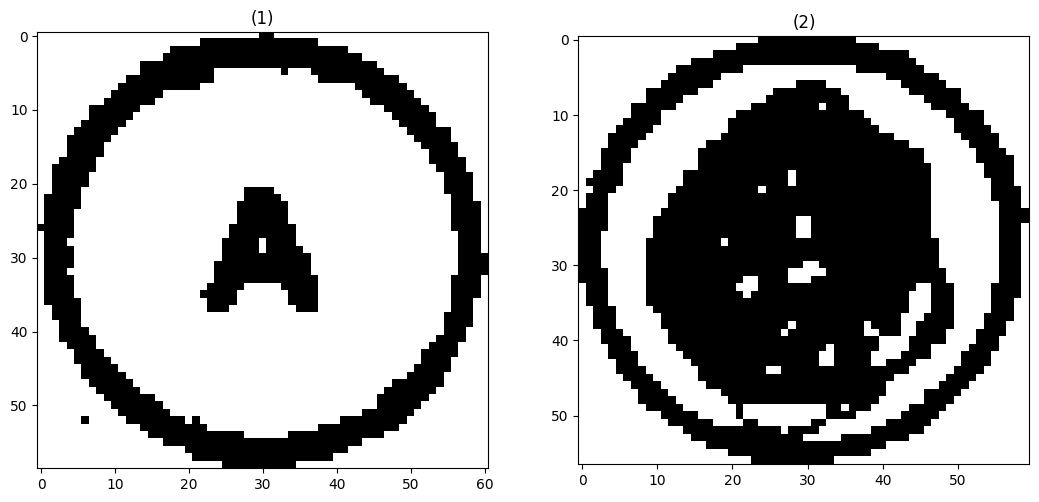

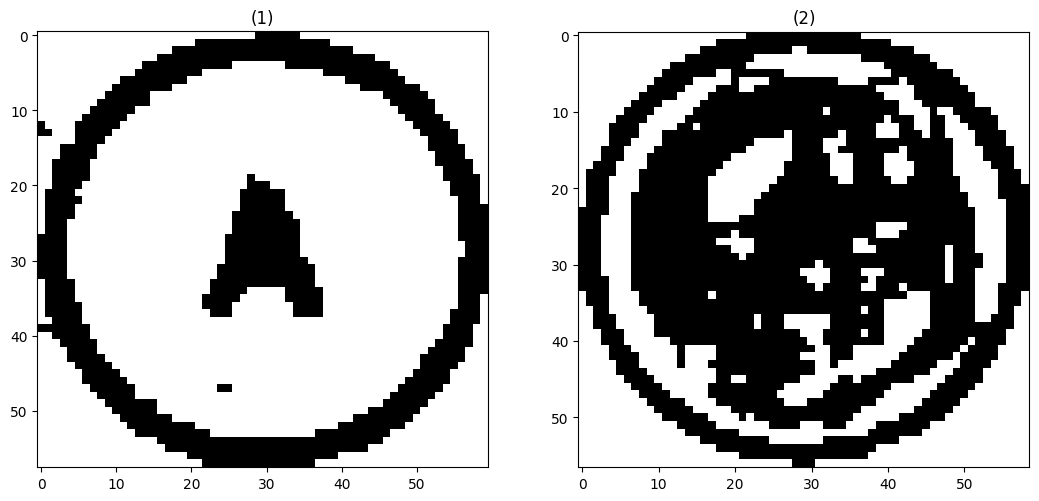

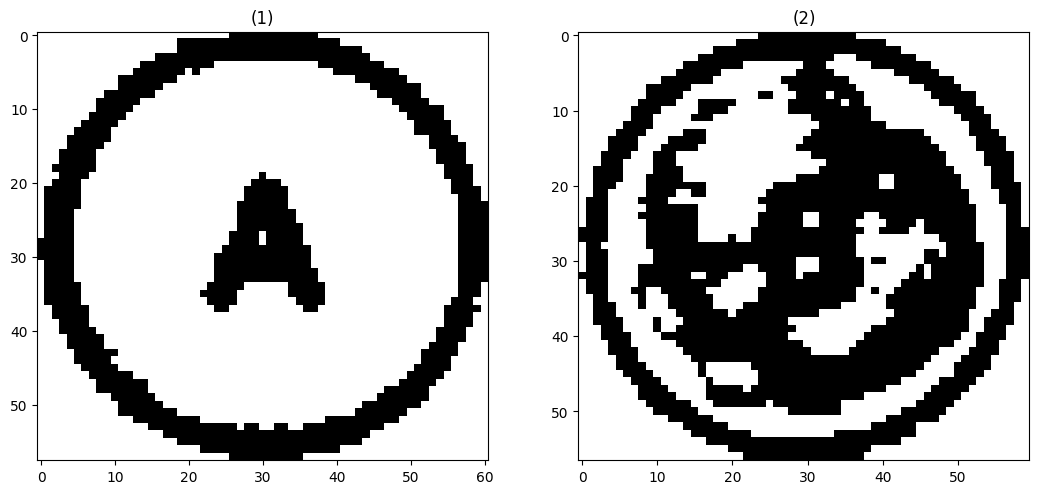

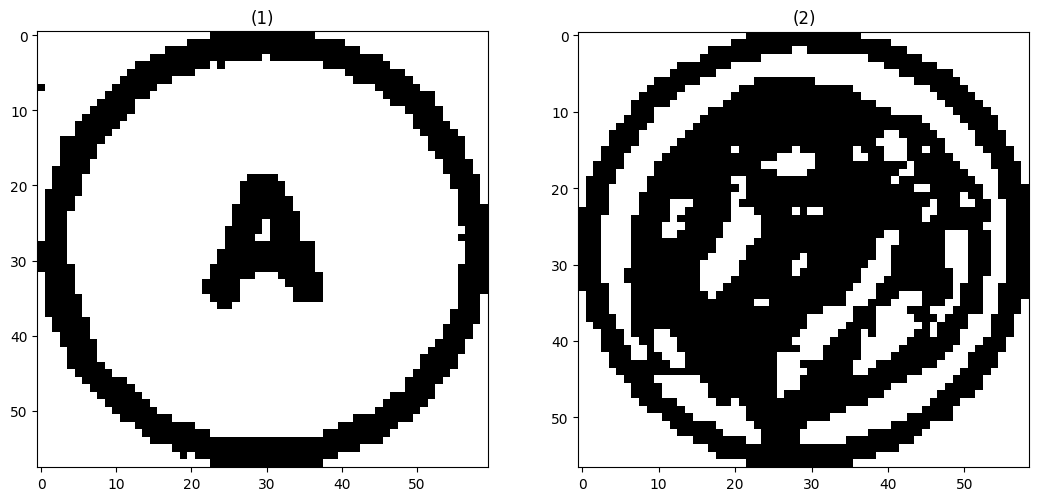

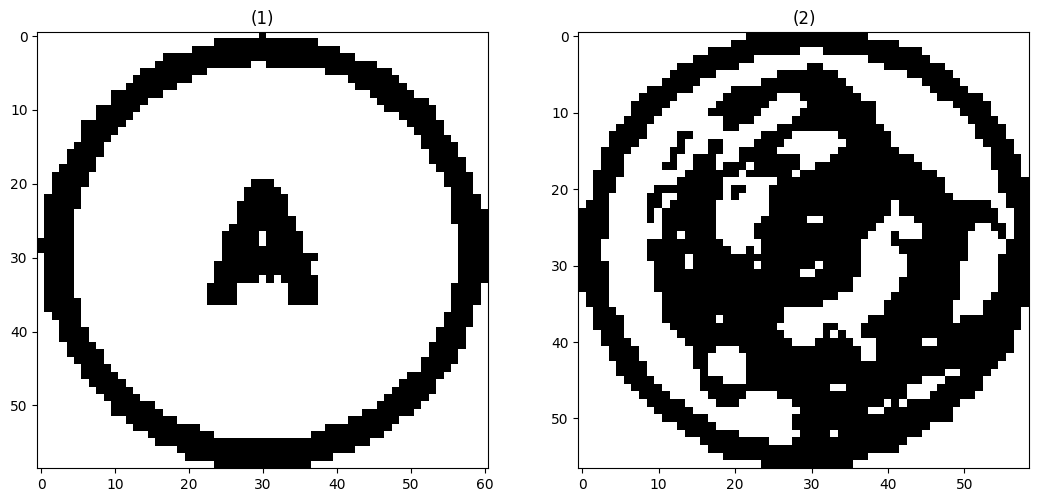

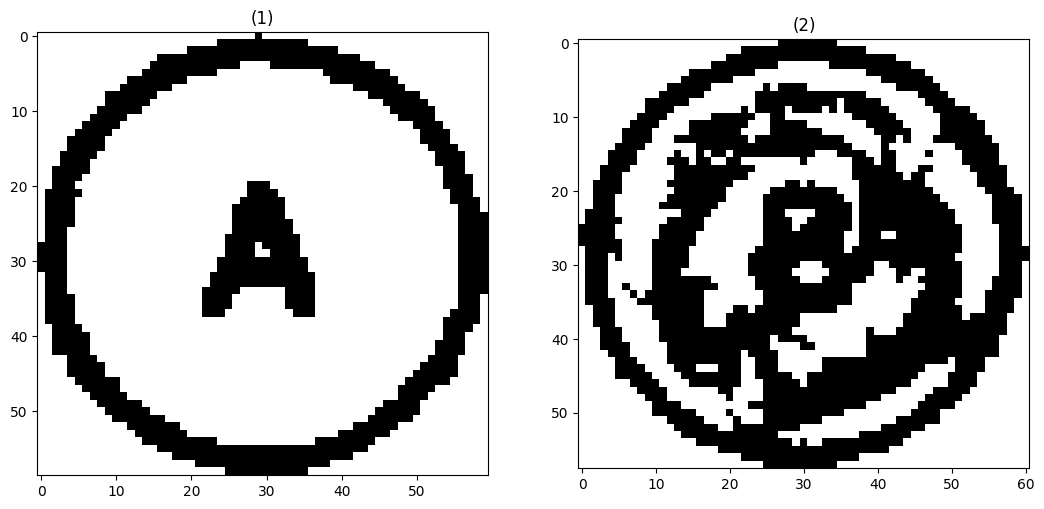

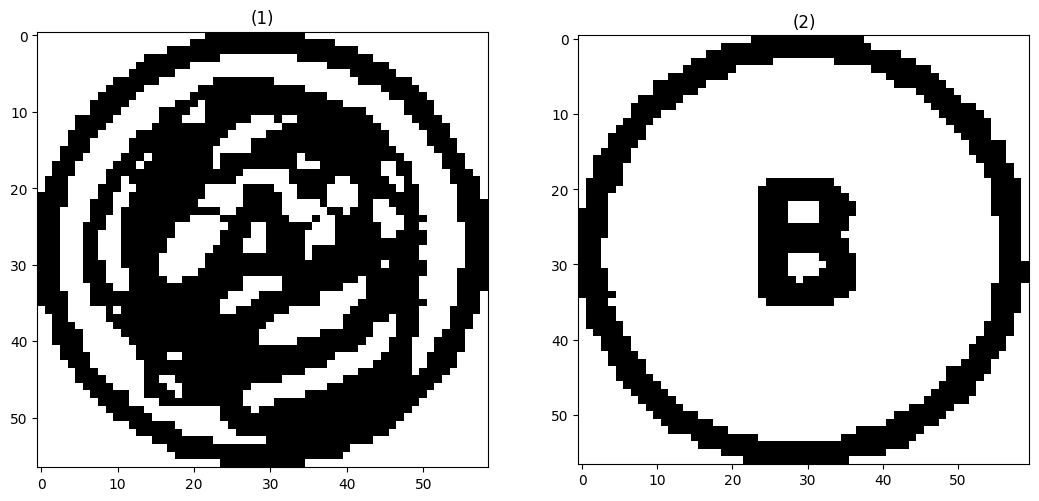

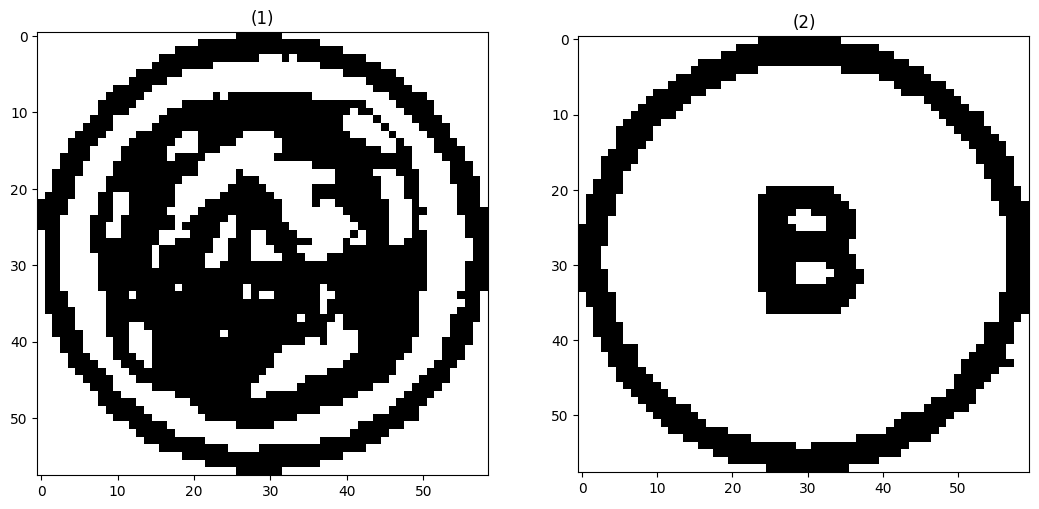

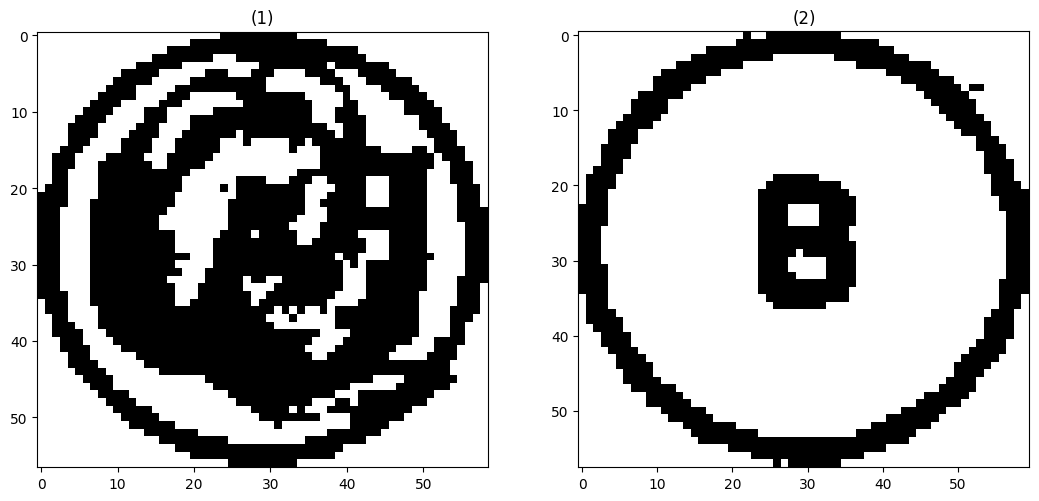

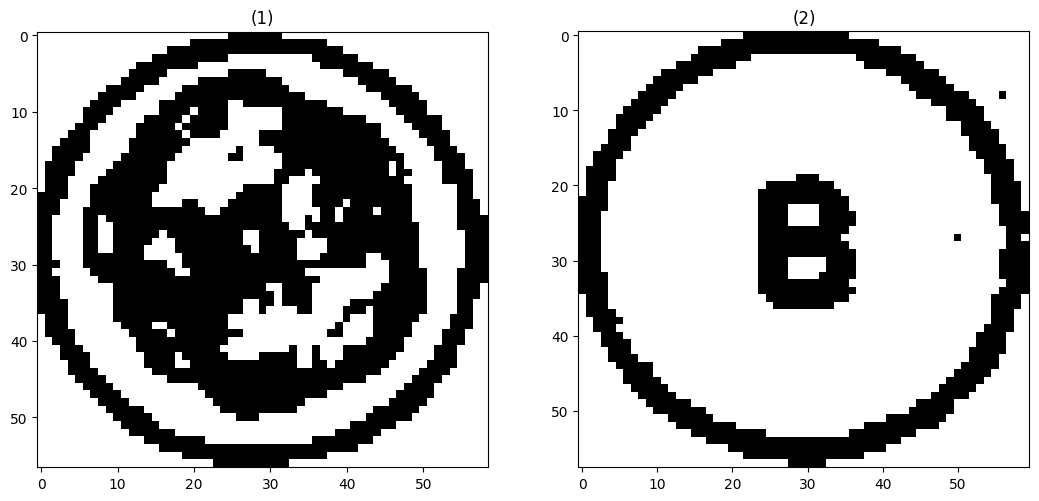

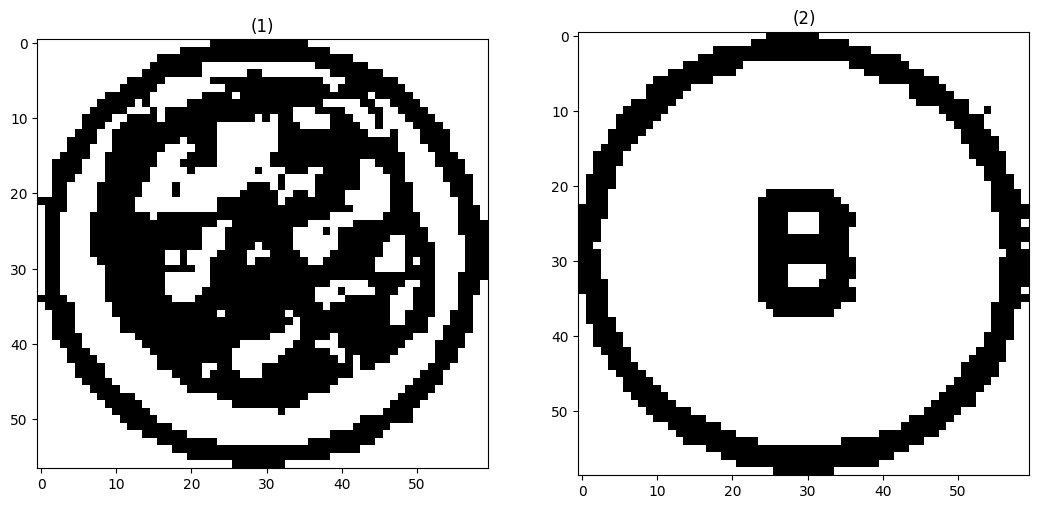

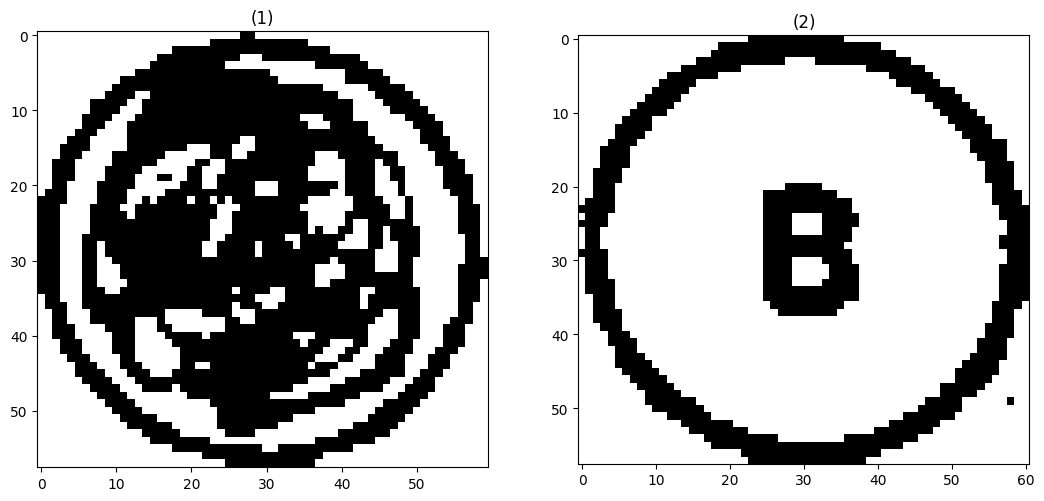

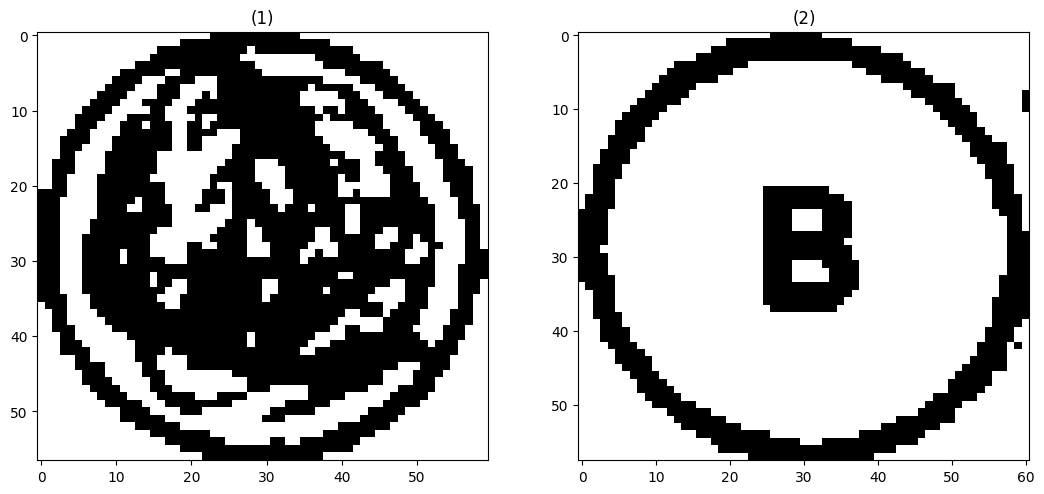

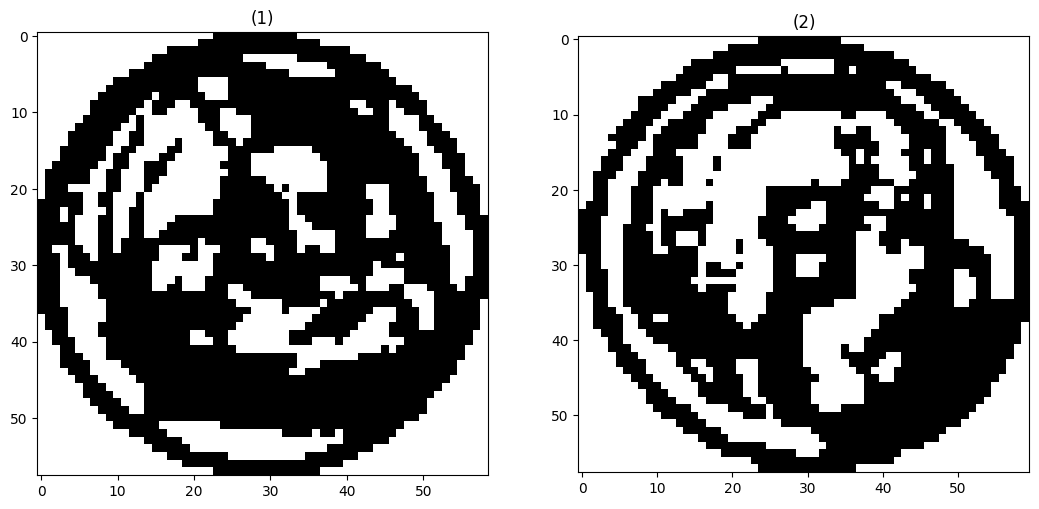

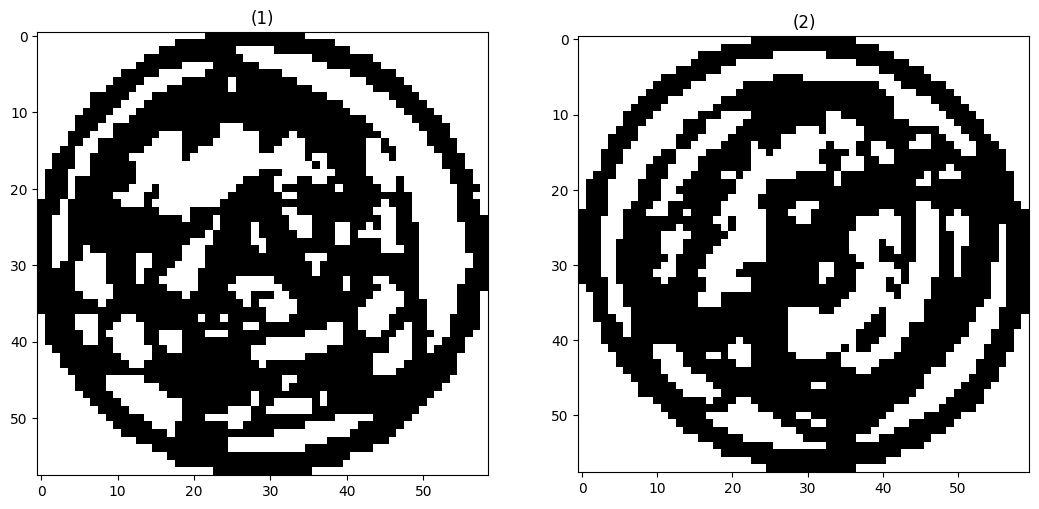

In [22]:
# print(groups_questions_answers[0][0].shape)
# print(len(groups_questions_answers[0][0]))
# show_images(groups_questions_answers[0])
count = 0
print("groups_questions_answers",len(groups_questions_answers))
for group in groups_questions_answers:
    print("group",len(group))
    for question in group:
        show_images(question)
        
                
        #print(question)
#         show_images(question)

In [23]:
question_index = 0
questions_final_answers = []
for group in groups_questions_answers:
#     group_ans = []
    for question in group:
        question_index = question_index+1
        ans = []
        for i in range(answer_count):
            choice = question[i]
            #print(np.sum(choice), 0.5*(255*choice.shape[0]*choice.shape[1]))
            if np.sum(choice) < 0.6*(255*choice.shape[0]*choice.shape[1]):
                ans.append(chr(ord('A')+i))
        print("answer(s) for question ",question_index,"is",ans)
        questions_final_answers.append(ans)
                

answer(s) for question  1 is ['A']
answer(s) for question  2 is ['A']
answer(s) for question  3 is ['A']
answer(s) for question  4 is ['A']
answer(s) for question  5 is ['A']
answer(s) for question  6 is ['A']
answer(s) for question  7 is ['A']
answer(s) for question  8 is ['B']
answer(s) for question  9 is ['B']
answer(s) for question  10 is ['B']
answer(s) for question  11 is ['B']
answer(s) for question  12 is ['B']
answer(s) for question  13 is ['B']
answer(s) for question  14 is ['B']
answer(s) for question  15 is ['B']
answer(s) for question  16 is ['B']
answer(s) for question  17 is ['B']
answer(s) for question  18 is ['B']
answer(s) for question  19 is ['B']
answer(s) for question  20 is ['B']
answer(s) for question  21 is ['B']
answer(s) for question  22 is ['A']
answer(s) for question  23 is ['A']
answer(s) for question  24 is ['A']
answer(s) for question  25 is ['A']
answer(s) for question  26 is ['A']
answer(s) for question  27 is ['A']
answer(s) for question  28 is ['A']
a

In [24]:
actual_answers = []
with open("answers.txt") as file:
    lines = file.readlines()
    for line in lines:
        actual_answers.append(line.split())
print(actual_answers)

# Convert answers to integers
#actual_answers = [list(map(int,i)) for i in actual_answers]
print(len(actual_answers))
data = {"code":["12345"],"name":[ocr(boxes_croped_images[0])]}
for i in range(len(questions_final_answers)):
    questions_final_answers[i].sort()
    actual_answers[i].sort()
    data["Q"+str(i+1)] = [1 if questions_final_answers[i] == actual_answers[i] else 0]

print(data)


df = pd.DataFrame(data)
with pd.ExcelWriter("answers.xlsx",mode="a",if_sheet_exists="overlay") as writer:
    df.to_excel(writer, startrow = writer.sheets['bubble sheet'].max_row,sheet_name="bubble sheet",index=False,header = False) 
    


[['A'], ['A'], ['A'], ['A'], ['A'], ['A'], ['A'], ['B'], ['B'], ['B'], ['B'], ['B'], ['B'], ['B'], ['B'], ['B'], ['B'], ['B'], ['B'], ['B'], ['B'], ['A'], ['A'], ['A'], ['A'], ['A'], ['A'], ['A'], ['A'], ['A']]
30
{'code': ['12345'], 'name': ['Ahmedsabry'], 'Q1': [1], 'Q2': [1], 'Q3': [1], 'Q4': [1], 'Q5': [1], 'Q6': [1], 'Q7': [1], 'Q8': [1], 'Q9': [1], 'Q10': [1], 'Q11': [1], 'Q12': [1], 'Q13': [1], 'Q14': [1], 'Q15': [1], 'Q16': [1], 'Q17': [1], 'Q18': [1], 'Q19': [1], 'Q20': [1], 'Q21': [1], 'Q22': [1], 'Q23': [1], 'Q24': [1], 'Q25': [1], 'Q26': [1], 'Q27': [1], 'Q28': [1], 'Q29': [0], 'Q30': [0]}


In [25]:
# # Read image.
# img = cv.imread('dataset/inputs/Four.png',0)

# # use canny to detect edges
# cannyEdges = cannyEdge(img)

# white_img_contours = np.ones(img.shape)
# contours, hierarchy = cv.findContours(cannyEdges, 
#     cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

# cv.drawContours(white_img_contours, contours, -1, (0,255,0), 3)

# show_images([white_img_contours])
# # Blur using 3 * 3 kernel.
# #gray_blurred = cv.blur(img, (3, 3))

# white_img = np.ones(img.shape)

# # Apply Hough transform on the blurred image.
# detected_circles = cv.HoughCircles(white_img_contours, 
#                    cv.HOUGH_GRADIENT, 1, 20, param1 = 50,
#                param2 = 30, minRadius = 1, maxRadius = 40)
  
# # Draw circles that are detected.
# if detected_circles is not None:
  
#     # Convert the circle parameters a, b and r to integers.
#     detected_circles = np.uint16(np.around(detected_circles))
  
#     for pt in detected_circles[0, :]:
#         a, b, r = pt[0], pt[1], pt[2]
  
#         # Draw the circumference of the circle.
#         cv.circle(img, (a, b), r, (0, 255, 0), 2)
  
#         # Draw a small circle (of radius 1) to show the center.
#         cv.circle(white_img, (a, b), 1, (0, 0, 255), 3)
# show_images([img,white_img])
